In [2]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
# Dense = Just your regular densely-connected NN layer.
# https://keras.io/layers/core/#dense
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Encoder Model:

In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

Decoder Model:

In [4]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [12]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 75us/step - loss: 0.1943 - val_loss: 0.1888
Epoch 2/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1866 - val_loss: 0.1819
Epoch 3/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.1803 - val_loss: 0.1760
Epoch 4/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1748 - val_loss: 0.1709
Epoch 5/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.1701 - val_loss: 0.1666
Epoch 6/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1658 - val_loss: 0.1625
Epoch 7/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1620 - val_loss: 0.1587
Epoch 8/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.1584 - val_loss: 0.1554
Epoch 9/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.1551 - val_loss: 0.1521
Epoch

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [13]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

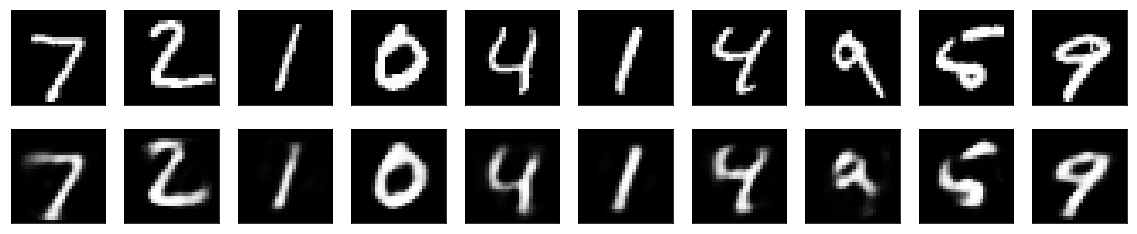

In [14]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Stacked Autoencoder

In [16]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [17]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 125us/step - loss: 0.3367 - val_loss: 0.2637
Epoch 2/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.2591 - val_loss: 0.2545
Epoch 3/5
60000/60000 [==============================] - 7s 110us/step - loss: 0.2461 - val_loss: 0.2355
Epoch 4/5
60000/60000 [==============================] - 7s 110us/step - loss: 0.2262 - val_loss: 0.2144
Epoch 5/5
60000/60000 [==============================] - 6s 108us/step - loss: 0.2097 - val_loss: 0.2029


In [19]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ValueError: Error when checking : expected input_5 to have shape (None, 784) but got array with shape (10000, 32)